# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S13

## Panel A

In [3]:
import pandas as pd
surface_firstorderterms = pd.read_csv(path+'FigS12/EBG_surface_layer_ddGs_scaled_from_additivetrait_orderorder1.txt',
                       sep='\t', index_col=0)
surface_firstorderterms=surface_firstorderterms.rename(columns={'actual_ddGs':'ddG','scaled_std':'ddG_std'})

core_firstorderterms = pd.read_csv(path+'FigS11/EBG_core_layer_ddGs_scaled_from_additivetrait_order2.txt',
                       sep='\t', index_col=0)
core_firstorderterms = core_firstorderterms.rename(columns={'actual_ddGs':'ddG','scaled_std':'ddG_std'})

folding_ddGs = pd.concat([core_firstorderterms[['ddG']],surface_firstorderterms[['ddG']]],axis=0)
folding_ddGs["wt"] = pd.Series(dtype="object")
folding_ddGs["mut"] = pd.Series(dtype="object")
for index, row in folding_ddGs.iterrows():
    folding_ddGs.at[index,'wt']=str(index[0])
    folding_ddGs.at[index,'pos']=int(index[1:-1])
    folding_ddGs.at[index,'mut']=str(index[-1])
folding_ddGs = folding_ddGs.sort_values('pos')

In [4]:
import pandas as pd
from protlearn.features import aaindex1

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aaind, inds = aaindex1(amino_acids)
DTS_AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids)

AAont = pd.read_csv(path+'FigS2/AAontology_SupplTable3.txt', sep='\t', encoding = "ISO-8859-1", index_col=0).drop('Unnamed: 5', axis=1)

aaindex_featureNames = pd.read_csv(path+'FigS2/AAindex_featureNames.txt',sep='\t', header=None)

hydrophobicity_scales = list(AAont[AAont['scale_description'].str.contains('hydrophobicity', case=False, na=False)].index)

hydrophobicity_scales_filtered = []
for scale in hydrophobicity_scales:
    if scale in DTS_AA_props.columns:
        hydrophobicity_scales_filtered.append(scale)

/users/project/prj004631/aescobedo/miniconda3/envs/BIO/lib/python3.12/site-packages/protlearn/features/aaindex1.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
wt_props = DTS_AA_props.loc[folding_ddGs[folding_ddGs["pos"].map(folding_ddGs["pos"].value_counts()) >= 3]['wt']]
mut_props = DTS_AA_props.loc[folding_ddGs[folding_ddGs["pos"].map(folding_ddGs["pos"].value_counts()) >= 3]['mut']]

prop_change_dict = {}

for scale in DTS_AA_props[hydrophobicity_scales_filtered].columns:
    dprop = mut_props[scale].values - wt_props[scale].values

    prop_change_dict[scale] = dprop

prop_change_df = pd.DataFrame(prop_change_dict)

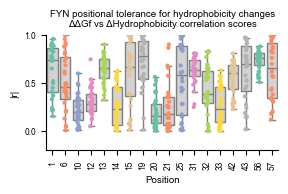

In [6]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'

r_all_pos = pd.DataFrame()
for pos in sorted([int(i) for i in list(folding_ddGs[folding_ddGs["pos"].map(folding_ddGs["pos"].value_counts()) >= 3]['pos'].unique())]):
    r_all = [pearsonr(prop_change_df.loc[folding_ddGs[folding_ddGs["pos"].map(folding_ddGs["pos"].value_counts()) >= 3].reset_index()['pos']==pos][prop],folding_ddGs[folding_ddGs["pos"].map(folding_ddGs["pos"].value_counts()) >= 3].loc[folding_ddGs[folding_ddGs["pos"].map(folding_ddGs["pos"].value_counts()) >= 3]['pos']==pos]['ddG'])[0] for prop in prop_change_df.columns]
    r_all = pd.DataFrame(r_all, index=prop_change_df.columns)
    r_all.columns = ['r']
    r_all['r_abs'] = abs(r_all['r'])
    r_all['pos'] = pos
    r_all_pos = pd.concat([r_all_pos, r_all], axis=0, ignore_index=False)
r_all_pos

fig,ax=plt.subplots(figsize=(3,1.5))
sns.boxplot(x=r_all_pos['pos'], y=r_all_pos['r_abs'], color='lightgray',showfliers=False)#,ax=ax_bot)
sns.stripplot(data=r_all_pos, x='pos', hue="pos", y="r_abs", color='black', size=3, jitter=True, legend=False, palette='Set2')
category_counts = r_all_pos['pos'].value_counts()

plt.xticks(rotation=90,fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Position', fontsize=7)
plt.ylabel('|r|', fontsize=7)
plt.ylim(-0.2,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('FYN positional tolerance for hydrophobicity changes\nΔΔGf vs ΔHydrophobicity correlation scores', fontsize=7)
plt.show()

## Panel B

In [7]:
### SECONDARY STRUCTURE WITH DSSP ###

from Bio.PDB import PDBParser, DSSP
from pathlib import Path
pdb_path = str(Path(path).expanduser())

parser = PDBParser()
structure = parser.get_structure('5zau', pdb_path+'/FigS6/5zau.pdb')

model = structure[0]

dssp = DSSP(model, pdb_path+'/FigS6/5zau.pdb', dssp='/users/project/prj004631/aescobedo/miniconda3/envs/BIO/bin/mkdssp')

dssp_list=[]
for key, value in dssp.property_dict.items():
    res_id, dssp_info = key, value
    if res_id[0] == 'A':
        dssp_list.append(dssp_info[2])
        
folding_ddGs["secondary_structure"] = pd.Series(dtype="object")
for index, row in folding_ddGs.iterrows():
    folding_ddGs.at[index,'secondary_structure'] = dssp_list[int(row.pos)-1]

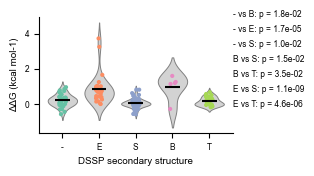

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import itertools

plt.rcParams['font.family'] = 'Arial'

def mann_whitney_tests(data, group_col, value_col):
    unique_groups = sorted(data[group_col].unique())
    comparisons = list(itertools.combinations(unique_groups, 2))
    p_values = {}

    for g1, g2 in comparisons:
        group1 = data[data[group_col] == g1][value_col]
        group2 = data[data[group_col] == g2][value_col]
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if p_value < 0.05:
            p_values[(g1, g2)] = p_value

    return p_values

def add_stat_annotations(fig, p_values):
    if not p_values:
        return

    x_pos = 0.9
    y_start = 0.9 
    y_step = 0.1
    
    for i, ((g1, g2), p_value) in enumerate(p_values.items()):
        text = f"{g1} vs {g2}: p = {p_value:.1e}"
        fig.text(x_pos, y_start - i * y_step, text, ha='left', va='center', fontsize=6, color='black')

def add_mean_lines(ax, data, group_col, value_col):
    means = data.groupby(group_col)[value_col].mean()

    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

    means = means.reindex(xticklabels)
    
    for i, (group, mean) in enumerate(means.items()):
        ax.hlines(y=mean, xmin=i - 0.2, xmax=i + 0.2, color='black', linewidth=1.5, zorder=3)

p_values_ddG = mann_whitney_tests(folding_ddGs, "secondary_structure", "ddG")

unique_ss = sorted(folding_ddGs["secondary_structure"].unique())

fig, ax = plt.subplots(figsize=(2.5, 1.5))
sns.violinplot(
    data=folding_ddGs, x="secondary_structure", y="ddG", hue="secondary_structure",
    split=False, ax=ax, inner=None, linewidth=0.7, edgecolor='gray', palette=["lightgray"] * len(unique_ss)
)
sns.stripplot(data=folding_ddGs, x="secondary_structure", y="ddG", color='black', size=3, jitter=True, ax=ax, hue="secondary_structure", palette='Set2')

add_mean_lines(ax, folding_ddGs, "secondary_structure", "ddG")

add_stat_annotations(fig, p_values_ddG)

ax.set_xlabel("DSSP secondary structure", fontsize=7)
ax.set_ylabel("ΔΔG (kcal mol-1)", fontsize=7)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


## Panel C

In [9]:
coefs_core_sparse = pd.read_csv(path+'FigS11/EBG_core_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt',sep='\t')
coefs_core_sparse['Layer']='Core'
coefs_surface_sparse = pd.read_csv(path+'FigS12/EBG_surface_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt',sep='\t')
coefs_surface_sparse['Layer']='Surface'

folding_dddGs = pd.concat([coefs_core_sparse,coefs_surface_sparse],axis=0)
folding_dddGs = folding_dddGs.reset_index(drop=True)
folding_dddGs["mutation1"] = pd.Series(dtype="object")
folding_dddGs["mutation2"] = pd.Series(dtype="object")
for index, row in folding_dddGs.iterrows():
    folding_dddGs.at[index,'mutation1']=row.id_ref.split('_')[0]
    folding_dddGs.at[index,'mutation2']=row.id_ref.split('_')[1]
    
folding_dddGs=folding_dddGs.rename(columns={'scaled_ddGs':'dddG', 'mean_kcal/mol':'mean_kcal_mol'})
for index, row in folding_dddGs.iterrows():
    folding_dddGs.at[index,'primseqdist']=int(str(int(row.Pos.split('_')[1])-int(row.Pos.split('_')[0])))

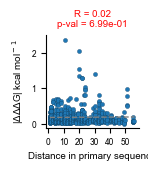

In [10]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots(figsize=(1.2,1.2))

folding_dddGs = folding_dddGs.sort_values('primseqdist', ascending=True)

ax=sns.scatterplot(x='primseqdist', y=folding_dddGs['dddG'].abs(), data=folding_dddGs ,edgecolor='k', linewidth=0.1, s=10)

scatter_ylim=ax.get_ylim()

x = folding_dddGs[['primseqdist']].to_numpy()
y = folding_dddGs[['dddG']].abs().to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')

ax.set_ylim(scatter_ylim)
ax.set_xticks(np.arange(0,60,10))
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.spines[['right', 'top']].set_visible(False)

plt.xlabel('Distance in primary sequence', fontsize=7)
plt.ylabel('|ΔΔΔG| kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7, color='red')

plt.show()

## Panel D

In [11]:
import Bio.PDB
import numpy as np
from Bio.PDB import PDBParser, PDBIO, Select
from Bio.SeqUtils import seq1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pathlib import Path


def calc_residue_dist(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues (except for backbone C, O and N)"""
    all_residue_one_distances=[]
    all_residue_one_distance_names=[]
    residue_one_id= residue_one.get_full_id()[3][1]
    residue_one_chain= residue_one.get_full_id()[2]
    residue_two_id= residue_two.get_full_id()[3][1]
    residue_two_chain= residue_two.get_full_id()[2]
    for atom_one in residue_one:
        atom_one_type=str(atom_one)
        atom_one_type=atom_one_type[6:-1]
        if atom_one_type[0] != 'H' and atom_one_type != 'N' and atom_one_type != 'C' and atom_one_type != 'O': #and atom_one_type != 'CA':
            all_atom_one_distances=[]
            all_atom_dist_names = []
            for atom_two in residue_two:
                atom_two_type=str(atom_two)
                atom_two_type=atom_two_type[6:-1]
                if atom_two_type[0] != 'H' and atom_two_type != 'N' and atom_two_type != 'C' and atom_two_type != 'O': #and atom_two_type != 'CA':
                    diff_vector = atom_one.coord - atom_two.coord
                    all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    all_atom_dist_names.append('/'+residue_one_chain+':'+str(residue_one_id)+'@'+atom_one_type+'/'+residue_two_chain+':'+str(residue_two_id)+'@'+atom_two_type)
            all_residue_one_distances.append(min(all_atom_one_distances))
            all_residue_one_distance_names.append(all_atom_dist_names[all_atom_one_distances.index(min(all_atom_one_distances))])
    return [min(all_residue_one_distances), all_residue_one_distance_names[all_residue_one_distances.index(min(all_residue_one_distances))]]

def calc_residue_dist_allatom(residue_one, residue_two) :
    """Returns the minimum distance between any atom in two residues"""
    all_residue_one_distances=[]
    all_residue_one_distance_names=[]
    residue_one_id= residue_one.get_full_id()[3][1]
    residue_one_chain= residue_one.get_full_id()[2]
    residue_two_id= residue_two.get_full_id()[3][1]
    residue_two_chain= residue_two.get_full_id()[2]
    for atom_one in residue_one:
        atom_one_type=str(atom_one)
        atom_one_type=atom_one_type[6]
        if atom_one_type != 'H':
            all_atom_one_distances=[]
            all_atom_dist_names = []
            for atom_two in residue_two:
                atom_two_type=str(atom_two)
                atom_two_type=atom_two_type[6]
                if atom_two_type != 'H':
                    diff_vector = atom_one.coord - atom_two.coord
                    all_atom_one_distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
                    all_atom_dist_names.append('/'+residue_one_chain+':'+str(residue_one_id)+'@'+atom_one_type+'/'+residue_two_chain+':'+str(residue_two_id)+'@'+atom_two_type)
                    #all_atom_one_distances.append(np.linalg.norm(atom_one.coord - atom_two.coord))
            all_residue_one_distances.append(min(all_atom_one_distances))
            all_residue_one_distance_names.append(all_atom_dist_names[all_atom_one_distances.index(min(all_atom_one_distances))])
    return [min(all_residue_one_distances), all_residue_one_distance_names[all_residue_one_distances.index(min(all_residue_one_distances))]]

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of side-chain distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers
    closest_atoms = pd.DataFrame(index=resseqs[chain_one.id],columns=resseqs[chain_two.id])
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            closest_atoms.at[row+resseqs[chain_one.id][0],col+resseqs[chain_one.id][1]-1]=calc_residue_dist(residue_one, residue_two)[1]
            answer[row, col] = calc_residue_dist(residue_one, residue_two)[0]
    return [answer, closest_atoms]

def calc_dist_matrix_allatom(chain_one, chain_two) :
    """Returns a matrix of minimum distances between two chains, considering all heavy atoms"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers
    closest_atoms = pd.DataFrame(index=resseqs[chain_one.id],columns=resseqs[chain_two.id])
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            closest_atoms.at[row+resseqs[chain_one.id][0],col+resseqs[chain_one.id][1]-1]=calc_residue_dist_allatom(residue_one, residue_two)[1]
            answer[row, col] = calc_residue_dist_allatom(residue_one, residue_two)[0]
    return [answer, closest_atoms]


pdb_code='5zau'
pdb_path = str(Path(path).expanduser())
pdb_filename = pdb_path + '/FigS6/' + pdb_code + '.pdb'

structure = Bio.PDB.PDBParser().get_structure(pdb_code, pdb_filename)
model = structure[0]

chain = 'A'

dist_matrix = calc_dist_matrix(model[chain], model[chain])[0]
closest_atoms = calc_dist_matrix(model[chain], model[chain])[1]

dist_matrix_allatom = calc_dist_matrix_allatom(model[chain], model[chain])[0]
closest_atoms_allatom = calc_dist_matrix_allatom(model[chain], model[chain])[1]

chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()} #Read amino acid sequence
resseqs = {chain.id:[residue.id[1] for residue in chain.get_residues()] for chain in structure.get_chains()} #Read sequence numbers

seq = chains[chain]
seq=list(seq)
seq_nr=resseqs[chain]

real_pos = [2,16,18,24,26,48,53]

core_dists=pd.DataFrame()
for pos1 in real_pos:
    for pos2 in real_pos:
        core_dists.at[pos1+1,pos2+1]=dist_matrix[pos1][pos2]

In [12]:
fyn_core_pos = [2,16,18,24,26,48,53]

folding_dddGs["mutation1"] = pd.Series(dtype="object")
folding_dddGs["mutation2"] = pd.Series(dtype="object")
folding_dddGs["mut1_ddG"] = pd.Series(dtype="object")
folding_dddGs["mut2_ddG"] = pd.Series(dtype="object")
folding_dddGs["single_muts_ddG_sum"] = pd.Series(dtype="object")
folding_dddGs["abs_single_muts_ddG_sum"] = pd.Series(dtype="object")
for index, row in folding_dddGs.iterrows():
    mut1 = row.id_ref.split('_')[0]
    mut2 = row.id_ref.split('_')[1]
    folding_dddGs.at[index,'mutation1']= mut1
    folding_dddGs.at[index,'mutation2']= mut2
    folding_dddGs.at[index,'mut1_ddG']= float(folding_ddGs.loc[mut1]['ddG'])
    folding_dddGs.at[index,'mut2_ddG']= float(folding_ddGs.loc[mut2]['ddG'])
    folding_dddGs.at[index,'single_muts_ddG_sum'] = float(folding_ddGs.loc[mut1]['ddG']) + float(folding_ddGs.loc[mut2]['ddG'])
    folding_dddGs.at[index,'abs_single_muts_ddG_sum'] = abs(float(folding_ddGs.loc[mut1]['ddG']) + float(folding_ddGs.loc[mut2]['ddG']))
initial_res_in_pdb=85-1
fyn_allatom_distances = pd.DataFrame(data=dist_matrix_allatom, index=np.arange(1,len(seq_nr)+1,1), columns=np.arange(1,len(seq_nr)+1,1))
fyn_sidechain_distances = pd.DataFrame(data=dist_matrix, index=np.arange(1,len(seq_nr)+1,1), columns=np.arange(1,len(seq_nr)+1,1))
folding_dddGs["3d_dist_allatom"] = pd.Series(dtype="object") 
folding_dddGs["3d_dist_sidechain"] = pd.Series(dtype="object") 
folding_dddGs["prim_seq_dist"] = pd.Series(dtype="object") 
folding_dddGs["closest_atoms_sidechains"] = pd.Series(dtype="object") 
folding_dddGs["closest_atoms_allatom"] = pd.Series(dtype="object") 
folding_dddGs["core_coupling"] = pd.Series(dtype="object")
folding_dddGs["3d_dist_allatom_category"] = pd.Series(dtype="object")
folding_dddGs["3d_dist_sidechain_category"] = pd.Series(dtype="object") 
for index, row in folding_dddGs.iterrows():
    folding_dddGs.at[index,'3d_dist_allatom']=fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])]
    folding_dddGs.at[index,'3d_dist_sidechain']=fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])]
    folding_dddGs.at[index,'prim_seq_dist']=abs(int(row.mutation1[1:-1])-int(row.mutation2[1:-1]))
    folding_dddGs.at[index,'closest_atoms_sidechains']=closest_atoms[int(row.mutation1[1:-1])+initial_res_in_pdb][int(row.mutation2[1:-1])+initial_res_in_pdb]
    folding_dddGs.at[index,'closest_atoms_allatom']=closest_atoms_allatom[int(row.mutation1[1:-1])+initial_res_in_pdb][int(row.mutation2[1:-1])+initial_res_in_pdb]

    if int(row.mutation1[1:-1]) in [i+1 for i in fyn_core_pos] or int(row.mutation2[1:-1]) in [i+1 for i in fyn_core_pos]:
        folding_dddGs.at[index,'core_coupling']=True
    else:
        folding_dddGs.at[index,'core_coupling']=False
    
    if fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] < 5:
        folding_dddGs.at[index,'3d_dist_allatom_category']='<5Å'
    elif fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 5 and fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 10:
        folding_dddGs.at[index,'3d_dist_allatom_category']='5-10Å'
    elif fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 10 and fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 15:
        folding_dddGs.at[index,'3d_dist_allatom_category']='10-15Å'
    else:
        folding_dddGs.at[index,'3d_dist_allatom_category']='>15Å'
        
    if fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] < 5:
        folding_dddGs.at[index,'3d_dist_sidechain_category']='<5Å'
    elif fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 5 and fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 10:
        folding_dddGs.at[index,'3d_dist_sidechain_category']='5-10Å'
    elif fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] > 10 and fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])] <= 15:
        folding_dddGs.at[index,'3d_dist_sidechain_category']='10-15Å'
    else:
        folding_dddGs.at[index,'3d_dist_sidechain_category']='>15Å'


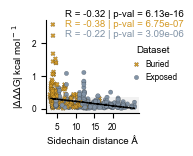

In [13]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm

n = 3

original_cmap = plt.get_cmap('Set3')
colors = original_cmap.colors[:n]

new_cmap = ListedColormap(colors)

new_colors = ['#D59C2A','#8294A7']
new_cmap_2 = ListedColormap(new_colors)

EBG_core_n_surf_couplings_vs_dist = folding_dddGs.reset_index(drop=True).copy()

layer_order = ['Core', 'Surface']

fig, ax = plt.subplots(figsize=(1.2,1.2))

ax=sns.scatterplot(x='3d_dist_sidechain', y=EBG_core_n_surf_couplings_vs_dist['mean_kcal_mol'].abs(), data=EBG_core_n_surf_couplings_vs_dist.sort_values('3d_dist_sidechain', ascending=True), hue='Layer', palette=new_colors,edgecolor='k', linewidth=0.1, s=10, style='Layer', hue_order=layer_order)

scatter_ylim=ax.get_ylim()

ax.axhspan(EBG_core_n_surf_couplings_vs_dist[EBG_core_n_surf_couplings_vs_dist['3d_dist_sidechain_category']=='<5Å']['mean_kcal_mol'].abs().mean(),ax.get_ylim()[0],facecolor='gray', alpha=0.1)

x = EBG_core_n_surf_couplings_vs_dist.sort_values('mean_kcal_mol')[['3d_dist_sidechain']].to_numpy()
y = EBG_core_n_surf_couplings_vs_dist.sort_values('mean_kcal_mol')[['mean_kcal_mol']].abs().to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r,p = pearsonr(y.ravel(),x.ravel())


x_core = EBG_core_n_surf_couplings_vs_dist.loc[EBG_core_n_surf_couplings_vs_dist['Layer']=='Core'].sort_values('mean_kcal_mol')[['3d_dist_sidechain']].to_numpy()
y_core = EBG_core_n_surf_couplings_vs_dist.loc[EBG_core_n_surf_couplings_vs_dist['Layer']=='Core'].sort_values('mean_kcal_mol')[['mean_kcal_mol']].abs().to_numpy()


model = LinearRegression()
model.fit(x_core, y_core)

y_pred_core = model.predict(x_core)
r_core,p_core = pearsonr(y_core.ravel(),x_core.ravel())


x_surf = EBG_core_n_surf_couplings_vs_dist.loc[EBG_core_n_surf_couplings_vs_dist['Layer']=='Surface'].sort_values('mean_kcal_mol')[['3d_dist_sidechain']].to_numpy()
y_surf = EBG_core_n_surf_couplings_vs_dist.loc[EBG_core_n_surf_couplings_vs_dist['Layer']=='Surface'].sort_values('mean_kcal_mol')[['mean_kcal_mol']].abs().to_numpy()


model = LinearRegression()
model.fit(x_surf, y_surf)

y_pred_surf = model.predict(x_surf)
r_surf,p_surf = pearsonr(y_surf.ravel(),x_surf.ravel())

plt.plot(x, y_pred, color='k', linewidth=1, linestyle='--')

ax.set_ylim(scatter_ylim)
ax.set_xticks(np.arange(5,25,5))
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.spines[['right', 'top']].set_visible(False)
legend_labels = {'Core': 'Buried', 'Surface': 'Exposed'}

legend = plt.legend(bbox_to_anchor=(1.5, 0.8), fontsize=6, frameon=False, handletextpad=0.1, title='Dataset')

for text in legend.get_texts():
    label = text.get_text()
    if label in legend_labels:
        text.set_text(legend_labels[label])
        
legend.get_title().set_fontsize(7)

plt.xlabel('Sidechain distance Å', fontsize=7)
plt.ylabel('|ΔΔΔG| kcal mol$^-$$^1$', fontsize=7)
plt.text(s='R = '+str(round(r,2))+ ' | p-val = '+'{:0.2e}'.format(p), fontsize=7, color='k', y=2.8, x=7)
plt.text(s='R = '+str(round(r_core,2))+ ' | p-val = '+'{:0.2e}'.format(p_core), fontsize=7, color='#D59C2A', y=2.5, x=7)
plt.text(s='R = '+str(round(r_surf,2))+ ' | p-val = '+'{:0.2e}'.format(p_surf), fontsize=7, color='#8294A7', y=2.2, x=7)

plt.show()

## Panel E

In [14]:
coefs= pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order2/task_1/weights/weights_Folding.txt',
                   sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    coefs.at[index,'order']=len(row.id.split('_'))
coefs_core_full = coefs.loc[coefs['order']==2].copy()

coefs= pd.read_csv(path+'Fig5/mochi/Core/RandomFYN_core_order2_sparse_regularized/task_4/weights/weights_Folding.txt',
                   sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    coefs.at[index,'order']=len(row.id.split('_'))
coefs_core_sparse = coefs.loc[coefs['order']==2].copy()

coefs_core_full["in_sparse_model"] = pd.Series(dtype="object")
for index, row in coefs_core_full.iterrows():
    if len(coefs_core_sparse.loc[coefs_core_sparse['id_ref']==row.id_ref])>0:
        coefs_core_full.at[index,'in_sparse_model']=True
    else:
        coefs_core_full.at[index,'in_sparse_model']=False

coefs= pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order2/task_1/weights/weights_Folding.txt',
                   sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    coefs.at[index,'order']=len(row.id.split('_'))
coefs_surface_full = coefs.loc[coefs['order']==2].copy()

coefs= pd.read_csv(path+'Fig5/mochi/Surface/RandomFYN_surface_order2_sparse_regularized/task_4/weights/weights_Folding.txt',
                   sep='\t')
coefs.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    coefs.at[index,'order']=len(row.id.split('_'))
coefs_surface_sparse = coefs.loc[coefs['order']==2].copy()

coefs_surface_full["in_sparse_model"] = pd.Series(dtype="object")
for index, row in coefs_surface_full.iterrows():
    if len(coefs_surface_sparse.loc[coefs_surface_sparse['id_ref']==row.id_ref])>0:
        coefs_surface_full.at[index,'in_sparse_model']=True
    else:
        coefs_surface_full.at[index,'in_sparse_model']=False

In [15]:
all_folding_dddGs = pd.concat([coefs_core_full,coefs_surface_full],axis=0)
all_folding_dddGs = all_folding_dddGs.reset_index(drop=True)
all_folding_dddGs["mutation1"] = pd.Series(dtype="object")
all_folding_dddGs["mutation2"] = pd.Series(dtype="object")
for index, row in all_folding_dddGs.iterrows():
    all_folding_dddGs.at[index,'mutation1']=row.id_ref.split('_')[0]
    all_folding_dddGs.at[index,'mutation2']=row.id_ref.split('_')[1]
    all_folding_dddGs.at[index,'mut1_ddG']=folding_ddGs.loc[row.id_ref.split('_')[0]]['ddG']
    all_folding_dddGs.at[index,'mut2_ddG']=folding_ddGs.loc[row.id_ref.split('_')[1]]['ddG']
    all_folding_dddGs.at[index,'single_muts_ddG_sum']=folding_ddGs.loc[row.id_ref.split('_')[0]]['ddG']+folding_ddGs.loc[row.id_ref.split('_')[1]]['ddG']
all_folding_dddGs['abs_mean_kcal_mol'] = all_folding_dddGs['mean_kcal_mol'].abs()

In [16]:
for index, row in all_folding_dddGs.iterrows():
    all_folding_dddGs.at[index,'3d_dist_allatom']=fyn_allatom_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])]
    all_folding_dddGs.at[index,'3d_dist_sidechain']=fyn_sidechain_distances[int(row.mutation1[1:-1])][int(row.mutation2[1:-1])]

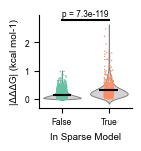

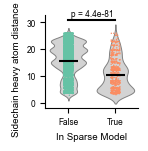

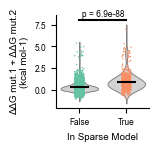

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.rcParams['font.family'] = 'Arial'

def mann_whitney_test(data, group_col, value_col):
    group1 = data[data[group_col] == True][value_col]
    group2 = data[data[group_col] == False][value_col]
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return p_value

def add_stat_annotation(ax, p_value):
    x1, x2 = 0, 1
    y_max = ax.get_ylim()[1]
    h = (y_max - ax.get_ylim()[0]) * 0.01
    y = y_max * 1
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')

    text = f"p = {p_value:.1e}"
    ax.text((x1 + x2) * 0.5, y + h * 2.5, text, ha='center', va='bottom', color='black', fontsize=6)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def add_mean_lines(ax, data, group_col, value_col):
    means = data.groupby(group_col)[value_col].mean()
    for i, (group, mean) in enumerate(means.items()):
        ax.hlines(y=mean, xmin=i - 0.2, xmax=i + 0.2, color='black', linewidth=1.5, zorder=3)  # Black mean lines

p_value_dddG = mann_whitney_test(all_folding_dddGs, "in_sparse_model", "abs_mean_kcal_mol")
p_value_3d_dist = mann_whitney_test(all_folding_dddGs, "in_sparse_model", "3d_dist_sidechain")
p_value_singles_ddG_sum = mann_whitney_test(all_folding_dddGs, "in_sparse_model", "single_muts_ddG_sum")

fig, ax = plt.subplots(figsize=(1.2, 1.2))
sns.violinplot(
    data=all_folding_dddGs, x="in_sparse_model", y="abs_mean_kcal_mol", hue="in_sparse_model",
    split=False, ax=ax, inner=None, linewidth=0.7, edgecolor='gray', palette=["lightgray", "lightgray"]
)
sns.stripplot(data=all_folding_dddGs, x="in_sparse_model", y="abs_mean_kcal_mol", color='black', size=1, jitter=True, ax=ax, palette='Set2', hue='in_sparse_model')
add_mean_lines(ax, all_folding_dddGs, "in_sparse_model", "abs_mean_kcal_mol")  # Add mean lines
add_stat_annotation(ax, p_value_dddG)
ax.set_xlabel("In Sparse Model", fontsize=7)
ax.set_ylabel("|ΔΔΔG| (kcal mol-1)", fontsize=7)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.legend_.remove()
plt.show()

fig, ax = plt.subplots(figsize=(1.2, 1.2))
sns.violinplot(
    data=all_folding_dddGs, x="in_sparse_model", y="3d_dist_sidechain", hue="in_sparse_model",
    split=False, ax=ax, inner=None, linewidth=0.7, edgecolor='gray', palette=["lightgray", "lightgray"]
)
sns.stripplot(data=all_folding_dddGs, x="in_sparse_model", y="3d_dist_sidechain", color='black', size=1, jitter=True, ax=ax, palette='Set2', hue='in_sparse_model')
add_mean_lines(ax, all_folding_dddGs, "in_sparse_model", "3d_dist_sidechain")  # Add mean lines
add_stat_annotation(ax, p_value_3d_dist)
ax.set_xlabel("In Sparse Model", fontsize=7)
ax.set_ylabel("Sidechain heavy atom distance (Å)", fontsize=7)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.legend_.remove()
plt.show()

fig, ax = plt.subplots(figsize=(1.2, 1.2))
sns.violinplot(
    data=all_folding_dddGs, x="in_sparse_model", y="single_muts_ddG_sum", hue="in_sparse_model",
    split=False, ax=ax, inner=None, linewidth=0.7, edgecolor='gray', palette=["lightgray", "lightgray"]
)
sns.stripplot(data=all_folding_dddGs, x="in_sparse_model", y="single_muts_ddG_sum", color='black', size=1, jitter=True, ax=ax, palette='Set2', hue='in_sparse_model')
add_mean_lines(ax, all_folding_dddGs, "in_sparse_model", "single_muts_ddG_sum")  # Add mean lines
add_stat_annotation(ax, p_value_singles_ddG_sum)
ax.set_xlabel("In Sparse Model", fontsize=7)
ax.set_ylabel("ΔΔG mut.1 + ΔΔG mut.2\n(kcal mol-1)", fontsize=7)
ax.tick_params(axis='x', labelsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.legend_.remove()
plt.show()


## Panel F

In [18]:
split1 = all_folding_dddGs['id_ref'].str.split('_', expand = True)
split2 = pd.concat([split1[0].str.extract(r'([A-Za-z]+)(\d+)([A-Za-z]+)', expand=True),
           split1[1].str.extract(r'([A-Za-z]+)(\d+)([A-Za-z]+)', expand=True)], axis=1)
split2.columns = ['wt1', 'pos1', 'mut1', 'wt2', 'pos2', 'mut2']
split2 = split2.reset_index(drop=True)

In [19]:
wt1_props = DTS_AA_props.loc[split2['wt1']]
mut1_props = DTS_AA_props.loc[split2['mut1']]
wt2_props = DTS_AA_props.loc[split2['wt2']]
mut2_props = DTS_AA_props.loc[split2['mut2']]

prop_change_dict = {}

for scale in DTS_AA_props.columns:
    dprop1 = mut1_props[scale].values - wt1_props[scale].values
    dprop2 = mut2_props[scale].values - wt2_props[scale].values

    prop_val = dprop1 + dprop2

    prop_change_dict[scale] = prop_val

prop_change_df = pd.DataFrame(prop_change_dict)


In [20]:
aaindex_featureNames = pd.read_csv(path+'FigS2/AAindex_featureNames.txt',sep='\t', header=None)
aaindex_featureNames = aaindex_featureNames[0].str.split(' ', n=1, expand = True)
aaindex_id = aaindex_featureNames[0]
aaindex_featureNames = pd.concat([aaindex_id, aaindex_featureNames[1].str.split('(', n=1, expand=True)], axis=1)
aaindex_featureNames.columns = ['id', 'name', 'source']
aaindex_featureNames['name'] = aaindex_featureNames['name'].str.removesuffix(' ')
aaindex_featureNames['source'] = aaindex_featureNames['source'].str.removesuffix(')')
aaindex_featureNames = aaindex_featureNames.set_index('id')

sum_all_in_sparse_model = [np.sum(prop_change_df.loc[all_folding_dddGs.reset_index(drop=True)['in_sparse_model']==True][prop]) for prop in prop_change_df.columns]
sum_all_in_sparse_model = pd.DataFrame(sum_all_in_sparse_model, index=prop_change_df.columns)
sum_all_in_sparse_model.columns = ['addition']
sum_all_in_sparse_model['abs_addition'] = abs(sum_all_in_sparse_model['addition'])
#sum_all_in_sparse_model['r_pval'] = [pearsonr(prop_change_df[prop],all_folding_dddGs.loc[all_folding_dddGs['in_sparse_model']==True]['dddG'])[1] for prop in prop_change_df.columns]
sum_all_in_sparse_model = sum_all_in_sparse_model.sort_values('addition', ascending=False)#.dropna(subset=['addition'], axis=0)
# annotate
sum_all_in_sparse_model['name'] = aaindex_featureNames.loc[sum_all_in_sparse_model.index, 'name']
sum_all_in_sparse_model['category'] = AAont.loc[sum_all_in_sparse_model.index, 'category']
sum_all_in_sparse_model['subcategory'] = AAont.loc[sum_all_in_sparse_model.index, 'subcategory']
sum_all_in_sparse_model = sum_all_in_sparse_model.sort_values('category',ascending=True)

sum_all_not_in_sparse_model = [np.sum(prop_change_df.loc[all_folding_dddGs.reset_index(drop=True)['in_sparse_model']==False][prop]) for prop in prop_change_df.columns]
sum_all_not_in_sparse_model = pd.DataFrame(sum_all_not_in_sparse_model, index=prop_change_df.columns)
sum_all_not_in_sparse_model.columns = ['addition']
sum_all_not_in_sparse_model['abs_addition'] = abs(sum_all_not_in_sparse_model['addition'])
#sum_all_not_in_sparse_model['r_pval'] = [pearsonr(prop_change_df[prop],all_folding_dddGs.loc[all_folding_dddGs['in_sparse_model']==True]['dddG'])[1] for prop in prop_change_df.columns]
sum_all_not_in_sparse_model = sum_all_not_in_sparse_model.sort_values('addition', ascending=False)#.dropna(subset=['addition'], axis=0)
# annotate
sum_all_not_in_sparse_model['name'] = aaindex_featureNames.loc[sum_all_not_in_sparse_model.index, 'name']
sum_all_not_in_sparse_model['category'] = AAont.loc[sum_all_not_in_sparse_model.index, 'category']
sum_all_not_in_sparse_model['subcategory'] = AAont.loc[sum_all_not_in_sparse_model.index, 'subcategory']
sum_all_not_in_sparse_model = sum_all_not_in_sparse_model.sort_values('category',ascending=True)

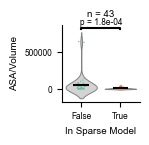

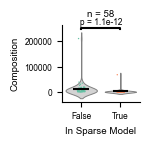

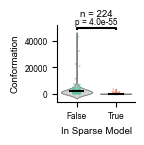

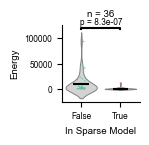

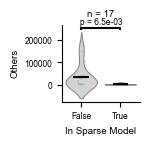

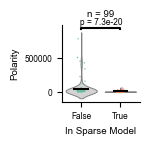

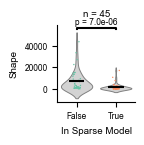

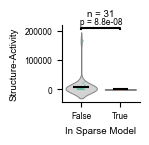

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.rcParams['font.family'] = 'Arial'

# Merge both datasets for plotting
sum_all_in_sparse_model["group"] = True
sum_all_not_in_sparse_model["group"] = False
merged_df = pd.concat([sum_all_in_sparse_model, sum_all_not_in_sparse_model])

# Function to perform Mann-Whitney U test for each category
def mann_whitney_by_category(data, group_col, value_col, category_col):
    categories = data[category_col].unique()
    p_values = {}
    for category in categories:
        group1 = data[(data[group_col] == True) & (data[category_col] == category)][value_col]
        group2 = data[(data[group_col] == False) & (data[category_col] == category)][value_col]
        if len(group1) > 0 and len(group2) > 0:  # Ensure there are values to compare
            stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            p_values[category] = p_value
    return p_values

# Function to add significance annotation with scientific notation
def add_stat_annotation(ax, p_value):
    x1, x2 = 0, 1  # X locations of the groups
    y_max = ax.get_ylim()[1]
    h = (y_max - ax.get_ylim()[0]) * 0.01  # Adjust space above violins
    y = y_max * 1  # Increase space between line and violins
    
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')

    # Format p-value in scientific notation
    text = f"p = {p_value:.1e}"
    ax.text((x1 + x2) * 0.5, y + h * 4, text, ha='center', va='bottom', color='black', fontsize=6)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Function to add horizontal mean lines
def add_mean_lines(ax, data, group_col, value_col):
    means = data.groupby(group_col)[value_col].mean()
    for i, (group, mean) in enumerate(means.items()):
        ax.hlines(y=mean, xmin=i - 0.2, xmax=i + 0.2, color='black', linewidth=1.5, zorder=3)  # Black mean lines

# Compute p-values for each category
p_values = mann_whitney_by_category(merged_df, "group", "abs_addition", "category")

# Get total count of scales per category (assumed same in both groups)
n_per_category = merged_df.loc[merged_df['group']==True]["category"].value_counts()  # Assuming each category has same count in both groups

for category in list(merged_df['category'].unique()):

    p_value = p_values.get(category, None)    

    # Create the violin plot for the category
    fig, ax = plt.subplots(figsize=(1, 1))
    sns.violinplot(
        data=merged_df.loc[merged_df['category'] == category], x="group", y="abs_addition", hue="group",
        split=False, ax=ax, inner=None, linewidth=0.7, edgecolor='gray', palette=["lightgray", "lightgray"]
    )
    sns.stripplot(data=merged_df.loc[merged_df['category'] == category], x="group", y="abs_addition", color='black', size=1, jitter=True, ax=ax, palette='Set2', hue='group')
    
    # Add mean lines
    add_mean_lines(ax, merged_df.loc[merged_df['category'] == category], "group", "abs_addition")
    
    # Add significance annotation
    add_stat_annotation(ax, p_value)
    
    # Set labels
    ax.set_xlabel("In Sparse Model", fontsize=7)
    ax.set_ylabel(category, fontsize=7)
    ax.tick_params(axis='y', labelsize=6)
    ax.tick_params(axis='x', labelsize=6)
    ax.legend_.remove()

    # Add title with n
    ax.set_title(f'n = {n_per_category.loc[category]}', fontsize=7)

    plt.rcParams['svg.fonttype'] = 'none'

    plt.show()


## Panel G

0. LOAD DATA

In [22]:
scaled_core_couplings = pd.read_csv(path+'FigS11/EBG_core_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt', sep='\t', index_col=0)
scaled_core_couplings['Layer']='Core'
scaled_surface_couplings = pd.read_csv(path+'FigS12/EBG_surface_layer_order2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt', sep='\t', index_col=0)
scaled_surface_couplings['Layer']='Surface'
EBG_core_n_surf_couplings_vs_dist = pd.concat([scaled_core_couplings, scaled_surface_couplings],axis=0).reset_index(drop=True)
for index, row in EBG_core_n_surf_couplings_vs_dist.iterrows():
    EBG_core_n_surf_couplings_vs_dist.at[index,'mut1_ddG']= float(folding_ddGs.loc[row.mutation1]['ddG'])
    EBG_core_n_surf_couplings_vs_dist.at[index,'mut2_ddG']= float(folding_ddGs.loc[row.mutation2]['ddG'])

EBG_core_n_surf_couplings_vs_dist = EBG_core_n_surf_couplings_vs_dist.merge(
    folding_dddGs[['id_ref', '3d_dist_allatom', '3d_dist_sidechain', 'prim_seq_dist']],
    on='id_ref',
    how='left'
)

EBG_core_n_surf_couplings_vs_dist['abs_coupling'] = abs(EBG_core_n_surf_couplings_vs_dist['scaled_ddGs'])
EBG_core_n_surf_couplings_vs_dist['in_sparse_model'] = True
EBG_core_n_surf_couplings_vs_dist

,id,id_ref,Pos,Pos_ref,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,...,scaled_ddGs,scaled_ddG_std,Layer,mut1_ddG,mut2_ddG,3d_dist_allatom,3d_dist_sidechain,prim_seq_dist,abs_coupling,in_sparse_model
0,F3V_A5V,F3V_A5V,3_5,3_5,-0.414776,-0.367664,-0.388687,-0.340064,-0.368362,-0.397043,...,-0.214121,0.017165,Core,0.728658,3.247216,4.23414,6.718924,2,0.214121,True
1,F3V_Y9F,F3V_Y9F,3_9,3_9,-0.189553,-0.199586,-0.209303,-0.175037,-0.171210,-0.202117,...,-0.099890,0.013495,Core,0.728658,1.245265,12.412204,13.104068,6,0.099890,True
2,F3L_A11P,F3L_A11P,3_11,3_11,0.651820,0.446576,0.495525,0.534366,0.522797,0.510759,...,0.290197,0.032577,Core,1.647693,0.731914,15.764666,16.406666,8,0.290197,True
3,F3L_A11S,F3L_A11S,3_11,3_11,0.472351,0.393918,0.373825,0.427352,0.391821,0.409680,...,0.224467,0.032176,Core,1.647693,0.664380,15.764666,16.406666,8,0.224467,True
4,F3L_D16E,F3L_D16E,3_16,3_16,-0.132862,-0.096140,-0.150735,-0.078603,-0.194584,-0.121522,...,-0.066019,0.021980,Core,1.647693,-0.293092,14.399222,14.621079,13,0.066019,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,P56M_V57L,P56M_V57L,56_57,56_57,0.252047,0.318103,0.236279,0.334375,0.267342,0.233763,...,0.120597,0.016108,Surface,0.824935,-0.057821,1.321191,3.79586,1,0.120597,True
601,P56Q_V57L,P56Q_V57L,56_57,56_57,0.269748,0.263787,0.237217,0.267518,0.235958,0.337600,...,0.118352,0.016156,Surface,0.409956,-0.057821,1.321191,3.79586,1,0.118352,True
602,P56V_V57I,P56V_V57I,56_57,56_57,0.172870,0.270558,0.295993,0.160203,0.213969,0.203033,...,0.110833,0.025388,Surface,1.025474,0.189278,1.321191,3.79586,1,0.110833,True
603,P56V_V57L,P56V_V57L,56_57,56_57,-0.056528,-0.060503,-0.071179,-0.035038,-0.015614,-0.073491,...,-0.027700,0.012299,Surface,1.025474,-0.057821,1.321191,3.79586,1,0.027700,True


In [23]:
import pandas as pd

split1 = EBG_core_n_surf_couplings_vs_dist['id'].str.split('_', expand = True)
split2 = pd.concat([split1[0].str.extract(r'([A-Za-z]+)(\d+)([A-Za-z]+)', expand=True),
           split1[1].str.extract(r'([A-Za-z]+)(\d+)([A-Za-z]+)', expand=True)], axis=1)
split2.columns = ['wt1', 'pos1', 'mut1', 'wt2', 'pos2', 'mut2']
split2 = split2.reset_index(drop=True)

1. ENCODE BIOPHYSICAL FEATURES

In [24]:
from scipy.stats import gmean
from statistics import mean

pd.set_option('display.max_columns', None)

for index, row in EBG_core_n_surf_couplings_vs_dist.iterrows():
    EBG_core_n_surf_couplings_vs_dist.at[index,'single_muts_ddG_gmean'] = gmean([abs(row.mut1_ddG),abs(row.mut2_ddG)])
    EBG_core_n_surf_couplings_vs_dist.at[index,'single_muts_ddG_mean'] = mean([abs(row.mut1_ddG),abs(row.mut2_ddG)])
    EBG_core_n_surf_couplings_vs_dist.at[index,'single_muts_ddG_add'] = row.mut1_ddG+row.mut2_ddG

In [25]:
import pandas as pd
from protlearn.features import aaindex1

amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
aaind, inds = aaindex1(amino_acids, standardize='zscore')
DTS_AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids).reset_index().rename(columns={'index':'AA'})

AAont = pd.read_csv(path+'FigS2/AAontology_SupplTable3.txt', sep='\t', encoding = "ISO-8859-1", index_col=0).drop('Unnamed: 5', axis=1)

aaindex_featureNames = pd.read_csv(path+'FigS2/AAindex_featureNames.txt',sep='\t', header=None)

In [26]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

bestindices = {}
for prop in ['volume', 'hydrophobicity', 'polarity', 'molecular weight', 'bulkiness', 'net charge']:
    props_dict_simple = {}
    for index, row in AAont[AAont['scale_description'].str.contains(prop, case=False, na=False)].iterrows():
        props_dict_simple[index] = row.scale_description
    
    DTS_AA_props = pd.DataFrame(data=aaind, columns=inds, index=amino_acids).reset_index().rename(columns={'index': 'AA'})
    selectable = []
    for i in list(props_dict_simple.keys()) + ['AA']:
        if i in DTS_AA_props.columns:
            selectable.append(i)
    DTS_AA_props_simple = DTS_AA_props[selectable]
    DTS_AA_props_simple = DTS_AA_props_simple.set_index('AA')

    scale_scores = {}
    compensation = pd.DataFrame()
    for scale in DTS_AA_props_simple.columns:
        prop_wt1 = [DTS_AA_props_simple.loc[aa][scale] for aa in split2['wt1']]
        prop_mut1 = [DTS_AA_props_simple.loc[aa][scale] for aa in split2['mut1']]
        prop_wt2 = [DTS_AA_props_simple.loc[aa][scale] for aa in split2['wt2']]
        prop_mut2 = [DTS_AA_props_simple.loc[aa][scale] for aa in split2['mut2']]

        dprop1 = np.subtract(prop_mut1, prop_wt1)
        dprop2 = np.subtract(prop_mut2, prop_wt2)

        prop_val = []
        for i, j in zip(dprop1, dprop2):

            prop_val.append(i+j)
        compensation[scale] = prop_val

        X = compensation[[scale]]
        y = abs(EBG_core_n_surf_couplings_vs_dist['scaled_ddGs'])
        
        model = LinearRegression()
        model.fit(X, y)

        y_pred = model.predict(X)

        r, p =pearsonr(y,y_pred)
        
        scale_scores[scale] = abs(r)

    scale_scores_df = pd.DataFrame(list(scale_scores.items()), columns=['Scale', 'Pearson r']).sort_values(by='Pearson r', ascending=False)

    best_scale = scale_scores_df.iloc[0]['Scale']
    bestindices[best_scale] = prop

bestindices


{'BULH740102': 'volume',
 'CASG920101': 'hydrophobicity',
 'ZIMJ680103': 'polarity',
 'FASG760101': 'molecular weight',
 'ZIMJ680102': 'bulkiness',
 'KLEP840101': 'net charge'}

In [27]:
props_dict_simple = bestindices
props_dict_simple.update({'AA':'AA'})

DTS_AA_props_simple = DTS_AA_props[list(props_dict_simple.keys())]
DTS_AA_props_simple = DTS_AA_props_simple.rename(mapper=props_dict_simple, axis=1)

aromatics = list('FYWH')
for index, row in DTS_AA_props_simple.iterrows():
    if row.AA in aromatics:
        DTS_AA_props_simple.at[index, 'aromatic'] = 1
    else:
        DTS_AA_props_simple.at[index, 'aromatic'] = 0
DTS_AA_props_simple

DTS_AA_props_simple

,volume,hydrophobicity,polarity,molecular weight,bulkiness,net charge,AA,aromatic
0,-0.013460,0.203033,-0.636447,-1.589241,-0.856513,0.000000,A,0.0
1,-0.872361,1.886717,-0.567156,-0.523564,-0.422443,0.000000,C,0.0
2,-1.718442,-1.381611,1.690419,-0.126346,-0.816649,-2.236068,D,0.0
3,-0.769806,-1.282571,1.699783,0.340013,-0.398082,-2.236068,E,0.0
4,0.819801,0.995354,-0.620061,0.940329,0.981640,0.000000,F,1.0
5,-1.282582,-0.094088,-0.636447,-2.055267,-2.650373,0.000000,G,0.0
6,-0.590334,0.401113,1.779374,0.606931,-0.371506,0.000000,H,1.0
7,1.499230,1.391515,-0.630361,-0.190499,1.335983,0.000000,I,0.0
8,0.960815,-1.579692,1.681055,0.308767,0.075851,2.236068,K,0.0
9,1.922270,0.500153,-0.630361,-0.190499,1.335983,0.000000,L,0.0


In [28]:
import numpy as np
from scipy.stats import gmean

DTS_AA_props_simple = DTS_AA_props_simple.set_index('AA')

compensation = pd.DataFrame()
for prop in DTS_AA_props_simple.columns:
    prop_wt1 = [ DTS_AA_props_simple.loc[aa][prop] for aa in split2['wt1'] ]
    prop_mut1 = [ DTS_AA_props_simple.loc[aa][prop] for aa in split2['mut1'] ]
    prop_wt2 = [ DTS_AA_props_simple.loc[aa][prop] for aa in split2['wt2'] ]
    prop_mut2 = [ DTS_AA_props_simple.loc[aa][prop] for aa in split2['mut2'] ]
    
    dprop1 = np.subtract(prop_mut1, prop_wt1)
    dprop2 = np.subtract(prop_mut2, prop_wt2)
    prop_val = []
    for i, j in zip(dprop1, dprop2):
        prop_val.append(i+j)
    compensation[prop] = prop_val
DTS_AA_props_simple = DTS_AA_props_simple.reset_index().rename(columns={'index':'AA'})

2. ENCODE STRUCTURAL FEATURES

In [29]:
from Bio.PDB import PDBParser, DSSP
from pathlib import Path
pdb_path = str(Path(path).expanduser())

parser = PDBParser()
structure = parser.get_structure('5zau', pdb_path+'/FigS6/5zau.pdb')

model = structure[0]

dssp = DSSP(model, pdb_path+'/FigS6/5zau.pdb', dssp='/users/project/prj004631/aescobedo/miniconda3/envs/BIO/bin/mkdssp')

dssp_list=[]
for key, value in dssp.property_dict.items():
    res_id, dssp_info = key, value
    if res_id[0] == 'A':
        dssp_list.append(dssp_info[2])

EBG_core_n_surf_couplings_vs_dist["secondary_structure"] = pd.Series(dtype="object")
for index, row in EBG_core_n_surf_couplings_vs_dist.iterrows():
    EBG_core_n_surf_couplings_vs_dist.at[index,'secondary_structure'] = dssp_list[int(row.Pos.split('_')[0])-1]+dssp_list[int(row.Pos.split('_')[1])-1]

categories = list(EBG_core_n_surf_couplings_vs_dist['secondary_structure'].unique())

unique_groups = {}
group_counter = 0

for category in categories:
    sorted_category = tuple(sorted([category, category[::-1]]))
    if sorted_category not in unique_groups:
        unique_groups[sorted_category] = group_counter
        group_counter += 1

category_to_int = {cat: unique_groups[tuple(sorted([cat, cat[::-1]]))] for cat in categories}

EBG_core_n_surf_couplings_vs_dist['secondary_structure_encoded'] = EBG_core_n_surf_couplings_vs_dist['secondary_structure'].map(category_to_int)

In [30]:
categories = list(EBG_core_n_surf_couplings_vs_dist['secondary_structure'].unique())

unique_groups = {}
group_counter = 0

for category in categories:
    sorted_category = tuple(sorted([category, category[::-1]]))
    if sorted_category not in unique_groups:
        unique_groups[sorted_category] = group_counter
        group_counter += 1

category_to_int = {cat: unique_groups[tuple(sorted([cat, cat[::-1]]))] for cat in categories}

EBG_core_n_surf_couplings_vs_dist['secondary_structure_encoded'] = EBG_core_n_surf_couplings_vs_dist['secondary_structure'].map(category_to_int)

In [31]:
contacts = pd.read_csv(path+'FigS13/5zau_getcontacts.txt', header=1, sep='\t', names=['frame','interaction_type', 'atom1','atom2'])

contacts[['chain1','resty1','resno1','resat1','chain2','resty2','resno2','resat2','pair']]=['A','ALA',0,'C','A','ALA',0,'C','0_0']
for index, row in contacts.iterrows():
    contacts.at[index,'chain1']=row.atom1.split(':')[0]
    contacts.at[index,'resty1']=row.atom1.split(':')[1]
    contacts.at[index,'resno1']=int(row.atom1.split(':')[2])
    contacts.at[index,'resat1']=row.atom1.split(':')[3]
    contacts.at[index,'chain2']=row.atom2.split(':')[0]
    contacts.at[index,'resty2']=row.atom2.split(':')[1]
    contacts.at[index,'resno2']=int(row.atom2.split(':')[2])
    contacts.at[index,'resat2']=row.atom2.split(':')[3]
    
for index, row in contacts.iterrows():
    if row.resno1 < row.resno2:
        contacts.at[index,'pair']=str(int(row.resno1)-84)+'_'+str(int(row.resno2)-84)
    else:
        contacts.at[index,'pair']=str(int(row.resno2)-84)+'_'+str(int(row.resno1)-84)

counts = contacts.groupby(['pair', 'interaction_type'], as_index=False).size()

counts['size'] = counts['size'] / contacts['frame'].unique().size
interactions = counts.pivot(index='pair', columns='interaction_type', values='size').reset_index().fillna(0)
interactions


interaction_type,pair,hbbb,hbsb,hbss,hp,pc,ps,sb,ts,vdw
0,10_11,2.00,0.05,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,10_12,0.05,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.20
2,11_12,1.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00
3,11_13,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.40
4,11_16,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,3.90
...,...,...,...,...,...,...,...,...,...,...
214,9_18,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.55
215,9_19,1.60,0.00,0.0,0.0,0.0,0.15,0.0,0.0,5.20
216,9_35,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.60
217,9_50,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,1.20


In [32]:
import pickle
from scipy.stats import gmean

with open(pdb_path+'/FigS13/fyn_freesasa_list.pkl', 'rb') as file:
    freesasa_list = pickle.load(file)

with open(pdb_path+'/FigS13/fyn_shannon_entropies.pkl', 'rb') as file:
    shannon_entropies = pickle.load(file)

with open(pdb_path+'/FigS13/fyn_gini_indices.pkl', 'rb') as file:
    gini_indices = pickle.load(file)

with open(pdb_path+'/FigS13/closeness_list.pkl', 'rb') as file:
    closeness_list = pickle.load(file)

for index, row in EBG_core_n_surf_couplings_vs_dist.iterrows():
    pos_mut1 = int(row.mutation1[1:-1])-1
    pos_mut2 = int(row.mutation2[1:-1])-1
    
    rsa_mut1 = freesasa_list[pos_mut1]
    rsa_mut2 = freesasa_list[pos_mut2]
    EBG_core_n_surf_couplings_vs_dist.at[index,'RSA_gmean'] = gmean([rsa_mut1,rsa_mut2])
    EBG_core_n_surf_couplings_vs_dist.at[index,'RSA_mean'] = mean([rsa_mut1,rsa_mut2])

    shannon_mut1 = shannon_entropies[pos_mut1]
    shannon_mut2 = shannon_entropies[pos_mut2]
    EBG_core_n_surf_couplings_vs_dist.at[index,'shannon_gmean'] = gmean([shannon_mut1,shannon_mut2])
    EBG_core_n_surf_couplings_vs_dist.at[index,'shannon_mean'] = mean([shannon_mut1,shannon_mut2])
    
    gini_mut1 = gini_indices[pos_mut1]
    gini_mut2 = gini_indices[pos_mut2]
    EBG_core_n_surf_couplings_vs_dist.at[index,'gini_gmean'] = gmean([gini_mut1,gini_mut2])
    EBG_core_n_surf_couplings_vs_dist.at[index,'gini_mean'] = mean([gini_mut1,gini_mut2])

    closeness_mut1 = closeness_list[pos_mut1]
    closeness_mut2 = closeness_list[pos_mut2]
    EBG_core_n_surf_couplings_vs_dist.at[index,'closeness_gmean'] = gmean([closeness_mut1,closeness_mut2])
    EBG_core_n_surf_couplings_vs_dist.at[index,'closeness_mean'] = mean([closeness_mut1,closeness_mut2])

In [33]:
structural_couplings = EBG_core_n_surf_couplings_vs_dist.loc[EBG_core_n_surf_couplings_vs_dist['in_sparse_model']==True][['id', 'Pos','Layer', 'scaled_ddGs', 'scaled_ddG_std', '3d_dist_allatom', '3d_dist_sidechain', 'prim_seq_dist', 'single_muts_ddG_add','RSA_mean','abs_coupling']]

structural_couplings = structural_couplings.merge(interactions, left_on='Pos', right_on='pair', how='left').drop('pair', axis=1)

structural_couplings.loc[:,['hbbb','hbsb','hbss','pc','ps','sb','ts','vdw','hp']] = structural_couplings.loc[:,['hbbb','hbsb','hbss','pc','ps','sb','ts','vdw','hp']].fillna(0)

structural_couplings


,id,Pos,Layer,scaled_ddGs,scaled_ddG_std,3d_dist_allatom,3d_dist_sidechain,prim_seq_dist,single_muts_ddG_add,RSA_mean,abs_coupling,hbbb,hbsb,hbss,hp,pc,ps,sb,ts,vdw
0,F3V_A5V,3_5,Core,-0.214121,0.017165,4.23414,6.718924,2,3.975874,0.082417,0.214121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F3V_Y9F,3_9,Core,-0.099890,0.013495,12.412204,13.104068,6,1.973923,0.170579,0.099890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,F3L_A11P,3_11,Core,0.290197,0.032577,15.764666,16.406666,8,2.379608,0.222723,0.290197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F3L_A11S,3_11,Core,0.224467,0.032176,15.764666,16.406666,8,2.312074,0.222723,0.224467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,F3L_D16E,3_16,Core,-0.066019,0.021980,14.399222,14.621079,13,1.354601,0.127100,0.066019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,P56M_V57L,56_57,Surface,0.120597,0.016108,1.321191,3.79586,1,0.767115,0.759183,0.120597,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,P56Q_V57L,56_57,Surface,0.118352,0.016156,1.321191,3.79586,1,0.352136,0.759183,0.118352,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
602,P56V_V57I,56_57,Surface,0.110833,0.025388,1.321191,3.79586,1,1.214752,0.759183,0.110833,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
603,P56V_V57L,56_57,Surface,-0.027700,0.012299,1.321191,3.79586,1,0.967653,0.759183,0.027700,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. Merge, scale, remove multi co-linearities

In [34]:
from sklearn import preprocessing

comp_data = pd.concat([compensation, structural_couplings], axis=1).drop(['id', 'Pos','Layer', 'scaled_ddGs', 'scaled_ddG_std','abs_coupling'], axis=1)

scaler = preprocessing.StandardScaler().fit(comp_data)
comp_data_scaled = scaler.transform(comp_data)
comp_data_scaled = pd.DataFrame(comp_data_scaled, columns=comp_data.columns)

comp_data_scaled

,volume,hydrophobicity,polarity,molecular weight,bulkiness,net charge,aromatic,3d_dist_allatom,3d_dist_sidechain,prim_seq_dist,single_muts_ddG_add,RSA_mean,hbbb,hbsb,hbss,hp,pc,ps,sb,ts,vdw
0,0.541477,-0.260847,0.521716,0.101452,1.500180,-0.28133,-1.190293,-0.868893,-0.623996,-1.038227,2.932359,-1.589237,-0.337959,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
1,-0.100484,-0.260847,0.486793,-0.843809,0.434795,-0.28133,-1.190293,0.533195,0.440944,-0.759307,1.001049,-1.290566,-0.337959,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
2,0.699769,-1.648370,0.558146,0.358900,0.946950,-0.28133,-1.190293,1.107958,0.991765,-0.619847,1.392419,-1.113912,-0.337959,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
3,-0.496213,-1.429288,0.560407,0.143502,-0.074792,-0.28133,-1.190293,1.107958,0.991765,-0.619847,1.327268,-1.113912,-0.337959,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
4,1.007558,-0.699012,0.523474,0.101238,0.428377,-0.28133,-1.190293,0.873860,0.693958,-0.271198,0.403580,-1.437860,-0.337959,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,-0.012544,0.542456,0.520208,1.562037,-0.192883,-0.28133,0.528388,-1.368304,-1.111517,-1.107957,-0.163176,0.703486,1.940781,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
601,-0.540183,-0.625985,0.572969,1.496388,-0.423930,-0.28133,0.528388,-1.368304,-1.111517,-1.107957,-0.563512,0.703486,1.940781,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
602,0.295245,1.345759,0.487547,0.874224,0.489990,-0.28133,0.528388,-1.368304,-1.111517,-1.107957,0.268666,0.703486,1.940781,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749
603,0.585447,0.688511,0.487547,0.874224,0.489990,-0.28133,0.528388,-1.368304,-1.111517,-1.107957,0.030286,0.703486,1.940781,-0.187551,0.0,-0.2014,0.0,-0.057591,0.0,-0.125791,-0.366749


In [35]:
### CALCULATE VIF FOR EACH FEATURE AGAINST ALL OTHERS; REMOVE THE FEATURE WITH HIGHEST VIF; RECALCULATE ALL VIFs; REPEAT UNTIL ALL VIFs < 5 ###

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

highest_VIF = 100
comp_data_scaled_selected_features = comp_data_scaled.copy()

for col in comp_data_scaled_selected_features.columns:
    if comp_data_scaled_selected_features[col].nunique() <= 1:
        comp_data_scaled_selected_features = comp_data_scaled_selected_features.drop(columns=[col])


vif_data = pd.DataFrame()
vif_data['Variable'] = comp_data_scaled_selected_features.columns
vif_data['VIF'] = [variance_inflation_factor(comp_data_scaled_selected_features.values, i) for i in range(comp_data_scaled_selected_features.shape[1])]
for index, row in vif_data.iterrows():
    if math.isnan(row.VIF):
        comp_data_scaled_selected_features = comp_data_scaled_selected_features.drop(row['Variable'],axis=1)

while highest_VIF >= 5:
    
    vif_data = pd.DataFrame()
    vif_data['Variable'] = comp_data_scaled_selected_features.columns
    vif_data['VIF'] = [variance_inflation_factor(comp_data_scaled_selected_features.values, i) for i in range(comp_data_scaled_selected_features.shape[1])]
    highest_VIF = vif_data.sort_values('VIF',ascending=False).iloc[0]['VIF']
    if highest_VIF >=5:
        comp_data_scaled_selected_features = comp_data_scaled_selected_features.drop(vif_data.sort_values('VIF',ascending=False).iloc[0]['Variable'],axis=1)
    


vif_data = pd.DataFrame()
vif_data['Variable'] = comp_data_scaled_selected_features.columns
vif_data['VIF'] = [variance_inflation_factor(comp_data_scaled_selected_features.values, i) for i in range(comp_data_scaled_selected_features.shape[1])]

vif_data


,Variable,VIF
0,volume,4.140529
1,hydrophobicity,2.343129
2,polarity,4.172127
3,molecular weight,4.411234
4,bulkiness,4.763228
5,net charge,2.485496
6,aromatic,2.693720
7,3d_dist_sidechain,1.999998
8,prim_seq_dist,1.398533
9,single_muts_ddG_add,1.962919


4. Data split and model fitting

In [36]:
from sklearn.model_selection import train_test_split

x = comp_data_scaled_selected_features.loc[structural_couplings.loc[structural_couplings['Layer']=='Surface'].index]
y = abs(structural_couplings.loc[structural_couplings.loc[structural_couplings['Layer']=='Surface'].index]['abs_coupling'])

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [37]:
# testing model performance for different train/test ratios
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

ratios = [.1, .15, .2, .25]
print('ratio\tr_train\tr_test')
for ratio in ratios:
    # define train & test sets
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=ratio)
    
    # leave out 1/10 of data as in cv, but don't run cv 
    xtrain, xdiscarded, ytrain, ydiscarded = train_test_split(x, y, test_size=0.1)
    
    lm = LinearRegression()
    lm.fit(xtrain, ytrain)
    ytrain_pred = lm.predict(xtrain)
    ytest_pred = lm.predict(xtest)
    r_train = pearsonr(ytrain, ytrain_pred)[0]
    r_test = pearsonr(ytest, ytest_pred)[0]
    print('{}\t{}\t{}'.format(ratio, round(r_train, 2), round(r_test, 2)))

# for abs(ddG), use >0.25

ratio	r_train	r_test
0.1	0.58	0.77
0.15	0.59	0.51
0.2	0.58	0.61
0.25	0.58	0.55


In [38]:
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.stats import pearsonr

layers = ['All', 'Core', 'Surface']

intercepts_df=pd.DataFrame()
r_train_df=pd.DataFrame()
r_test_df =pd.DataFrame()
coefs_mean_df=pd.DataFrame()
coefs_std_df=pd.DataFrame()
coef_pval_mean_df=pd.DataFrame()
coef_pval_std_df=pd.DataFrame()
coef_pval_ci95_df=pd.DataFrame()
coef_pval_sem_df=pd.DataFrame()

for layer in layers:
    if layer == 'All':
        x = comp_data_scaled_selected_features
        y = abs(structural_couplings['scaled_ddGs'])
    else:
        x = comp_data_scaled_selected_features.loc[structural_couplings.loc[structural_couplings['Layer']==layer].reset_index(drop=True).index]
        y = abs(structural_couplings.loc[structural_couplings.loc[structural_couplings['Layer']==layer].reset_index(drop=True).index]['scaled_ddGs'])

    random_state = 13
    folds = 5
    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    
    cols = pd.concat([pd.Series('const'), pd.Series(x.columns)]).reset_index(drop=True)
    coefs = pd.DataFrame(index=cols)
    intercepts = []
    coef_pvals = pd.DataFrame(index=cols)
    r_train = []
    r_test = []
    for i, (train_index, test_index) in enumerate(kf.split(x)): # returns indices
        xtrain = x.iloc[train_index, :]
        xtest = x.iloc[test_index, :]
        ytrain = y[train_index]
        ytest = y[test_index]
        
        # build model
        xtrain2 = sm.add_constant(xtrain, has_constant='add')
        est = sm.OLS(list(ytrain), xtrain2)
        est2 = est.fit()
    
        fold_coefs = pd.DataFrame(est2.params, columns=[i])
        coefs = coefs.merge(fold_coefs, left_index=True, right_index=True)
        
        fold_pval = pd.DataFrame(est2.pvalues, columns=[i])
        coef_pvals = coef_pvals.merge(fold_pval, left_index=True, right_index=True)
    
        r_train.append(pearsonr(ytrain, est2.predict(xtrain2))[0])
        r_test.append(pearsonr(ytest, est2.predict(sm.add_constant(xtest, has_constant='add')))[0])
    intercepts = coefs.loc['const']
    mean_intercept = intercepts.mean()
    coefs = coefs.drop('const', axis=0)
    coef_pvals = coef_pvals.drop('const', axis=0)

    coefs_mean_df[layer]=coefs.mean(axis=1)
    coefs_std_df[layer]=coefs.std(axis=1)

    coef_pval_mean_df[layer]=coef_pvals.mean(axis=1)
    coef_pval_std_df[layer]=coef_pvals.std(axis=1)
    coef_pval_ci95_df[layer] = coef_pvals.sem(axis=1) * 1.96
    coef_pval_sem_df[layer] = coef_pvals.sem(axis=1)
    
    coefs[['mean', 'std']] = pd.concat([coefs.mean(axis=1), coefs.std(axis=1)], axis=1)
    coef_pvals[['mean', 'std']] = pd.concat([coef_pvals.mean(axis=1), coef_pvals.std(axis=1)], axis=1)
   
    
    intercepts_df[layer]=intercepts
    r_train_df[layer]=r_train
    r_test_df[layer]=r_test

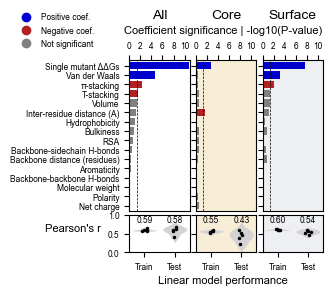

In [39]:
import seaborn as sns
from matplotlib.colors import to_rgba
from matplotlib.lines import Line2D

label_dict = {
    'molecular weight':'Molecular weight',
    'volume':'Volume',
    'hydrophobicity':'Hydrophobicity',
    'polarity':'Polarity',
    'hbbb':'Backbone-backbone H-bonds',
    'hbsb':'Backbone-sidechain H-bonds',
    'ts':'T-stacking',
    'vdw':'Van der Waals',
    'prim_seq_dist':'Backbone distance (residues)',
    '3d_dist_sidechain':'Inter-residue distance (A)',
    'single_muts_ddG_gmean':'Single mutant ddGs geometric mean',
    'net charge':'Net charge',
    'RSA_mean':'RSA',
    'pc':'π-cation',
    'ps':'π-stacking',
    'single_muts_ddG_mean':'Single mutant ΔΔGs',
    'single_muts_ddG_add':'Single mutant ΔΔGs',
    'bulkiness':'Bulkiness',
    'aromatic':'Aromaticity'
}    

df = np.log10(coef_pval_mean_df) * (-1)
df = df.sort_values('All', ascending=True)

pval_threshold = np.log10(0.05) * (-1)
x_max = df.values.max() * 1.01 

core_color = to_rgba("#E5BF66", alpha=0.25)
surface_color = to_rgba("#B9C2CD", alpha=0.25)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(2.5, 2.5), gridspec_kw={'height_ratios': [1, 0.25]})

for i, col in enumerate(df.columns):
    if col == "Core":
        bg_color = core_color
    elif col == "Surface":
        bg_color = surface_color
    else:
        bg_color = "white"

    axes[0, i].set_facecolor(bg_color)
    axes[1, i].set_facecolor(bg_color)

    color = [
        'firebrick' if value < 0 and pval+pval_std <0.05 else 'mediumblue' if value > 0 and pval+pval_std <0.05 else 'gray'
        for (value, pval, pval_std) in zip(coefs_mean_df.reindex(df.index)[col], coef_pval_mean_df.reindex(df.index)[col], coef_pval_std_df.reindex(df.index)[col])
    ]
    labels = [label_dict[feature] for feature in df.index]
    axes[0, i].barh(df.index, df[col], color=color)

    axes[0, i].set_title(col, pad=30, fontsize=10)

    if i == 0:
        axes[0, i].set_yticks(df.index)
        axes[0, i].set_yticklabels(labels, fontsize=6)
        axes[0, i].set_ylabel('')
        axes[1, i].set_ylabel("Pearson's r", fontsize=8, rotation=0, labelpad=25)
        axes[1, i].set_yticks(np.arange(0, 1.5, 0.5))
        axes[1, i].set_yticklabels(np.arange(0, 1.5, 0.5), fontsize=6)
    else:
        axes[0, i].set_yticks(df.index)
        axes[0, i].set_yticklabels([])
        axes[1, i].set_yticks(np.arange(0, 1.5, 0.5))
        axes[1, i].set_yticklabels([])
        
    axes[0, i].set_xlim(0, x_max)
    axes[0, i].set_ylim(-0.6, len(df)-0.4)
    axes[0, i].set_xticks(range(0, 12, 2))
    axes[0, i].set_xticklabels(axes[0, i].get_xticks(), fontsize=6)

    axes[0, i].xaxis.set_label_position('top')
    axes[0, i].xaxis.tick_top()

    axes[0, i].axvline(x=pval_threshold, linestyle='--', linewidth=0.5, color='black')

    traintest = pd.concat([r_train_df[col], r_test_df[col]], axis=1)
    traintest.columns = ['Train', 'Test']

    sns.violinplot(data=traintest, ax=axes[1, i], palette=["lightgray", "lightgray"], inner=None, linewidth=0)

    sns.stripplot(data=traintest, ax=axes[1, i], color="black", jitter=True, size=2.5)

    for j, data_type in enumerate(['Train', 'Test']):
        mean_value = traintest[data_type].mean()
        axes[1, i].text(j, 0.75, f'{mean_value:.2f}', ha='center', va='bottom', fontsize=6, color='black')  # y position fixed to 0.75

    axes[1, i].set_xticks([0, 1])
    axes[1, i].set_xticklabels(["Train", "Test"], fontsize=6)
    axes[1, i].set_xlabel('')
    axes[1, i].set_ylim(0, 1)

fig.text(0.5, 1, 'Coefficient significance | -log10(P-value)', ha='center', va='center', fontsize=8)
fig.text(0.5, 0, 'Linear model performance', ha='center', va='center', fontsize=8)

legend_elements = [
    Line2D([0], [0], marker='o', color='mediumblue', markersize=6, label='Positive coef.', linestyle='None'),
    Line2D([0], [0], marker='o', color='firebrick', markersize=6, label='Negative coef.', linestyle='None'),
    Line2D([0], [0], marker='o', color='gray', markersize=6, label='Not significant', linestyle='None')
]

fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.35, 1.1), fontsize=6, frameon=False)

plt.subplots_adjust(wspace=0.1, hspace=0.035)
plt.show()
